# Patches processing Notebook

The idea of this notebook is to process patches genereated by the slider window in Step 1.
This imply, reading patches from disk (.npy files), decode them, resized them and discard the ones with more than x% of gray pixels.

We should end up with a tf.dataset as a direct input for the model.

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 7 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (137 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 145655 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import matplotlib.image as mpimg

import random
import shutil
import pathlib

Mount drive to read an image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_root = "content/drive/My Drive/DL-Final_Project/"
raw_data = "/content/drive/My Drive/DL-Final_Project/Raw_data/slides/"
clean_data = "/content/drive/My Drive/DL-Final_Project/Clean_images/"
#Rutas IVAN
project_root = "content/drive/My Drive/Academic/Data_Science/ADL/hw/DL-Final_Project"
raw_data = "/content/drive/My Drive/Academic/Data_Science/ADL/hw/DL-Final_Project/Raw_data/slides/"
clean_data = "/content/drive/My Drive/Academic/Data_Science/ADL/hw/DL-Final_Project/Clean_images/"

In [0]:
slide_path = 'tumor_091.tif' 
tumor_mask_path = 'tumor_091_mask.tif'

In [6]:
slide = open_slide(raw_data+slide_path)
print ("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], 
                                                        slide.level_dimensions[0][1]))

mask = open_slide(raw_data+tumor_mask_path)
print ("Read WSI from %s with width: %d, height: %d" % (tumor_mask_path, 
                                                        mask.level_dimensions[0][0], 
                                                        mask.level_dimensions[0][1]))

Read WSI from tumor_091.tif with width: 61440, height: 53760
Read WSI from tumor_091_mask.tif with width: 61440, height: 53760


In [0]:
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [0]:
print(slide.level_dimensions[7][0])
print(slide.level_dimensions[7][1])

480
420


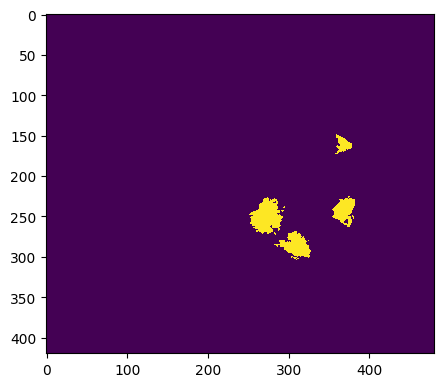

In [0]:
slide_image = read_slide(slide, x=0 , y=0, level=7, width=480, height=420)
mask_image = read_slide(mask , x=0 , y=0, level=7, width=480, height=420)[:,:,0]

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mask_image)

In [0]:
np.max(slide_image)

255

In [0]:
print(np.min(mask_image),np.max(mask_image))

0 1


Get a patch from original image, resize and save to disk

In [0]:
#read patches
!mkdir "/content/patches"

In [0]:
!unzip -q /content/drive/My\ Drive/DL-Final_Project/Clean_images/level6.zip -d ./patches

In [0]:
#paths to patches
pacthes_path_dir_pos = pathlib.Path("/content/patches/level6/positive")
pacthes_path_dir_neg = pathlib.Path("/content/patches/level6/negative")

patches_paths_pos_mask = list(pacthes_path_dir_pos.glob("*mask?*.npy"))
patches_paths_pos_mask = [str(path) for path in patches_paths_pos_mask]
patches_paths_pos_slide = list(pacthes_path_dir_pos.glob("*.npy"))
patches_paths_pos_slide = [str(path) for path in patches_paths_pos_slide if str(path) not in patches_paths_pos_mask]

patches_paths_neg_mask = list(pacthes_path_dir_neg.glob("*mask?*.npy"))
patches_paths_neg_mask = [str(path) for path in patches_paths_neg_mask]
patches_paths_neg_slide = list(pacthes_path_dir_neg.glob("*.npy"))
patches_paths_neg_slide = [str(path) for path in patches_paths_neg_slide if str(path) not in patches_paths_neg_mask]

In [0]:
patches_paths_pos_slide[:10]
print("len positive slides: {}, len positive masks: {}".format(len(patches_paths_pos_slide),len(patches_paths_pos_mask)))
print("len negative slides: {}, len negative masks: {}".format(len(patches_paths_neg_slide),len(patches_paths_neg_mask)))

len positive slides: 56, len positive masks: 56
len negative slides: 100, len negative masks: 100


In [0]:
img1 = np.load(patches_paths_pos_slide[0])

In [0]:
img1.shape

(182, 182, 3)

In [0]:
#from numpy array to image
img1_p = Image.fromarray(img1)
# summarize image details
print(img1_p.format)
print(img1_p.mode)
print(img1_p.size)

None
RGB
(182, 182)


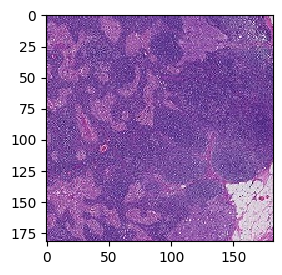

In [0]:
plt.figure(figsize=(3,3), dpi=100)
plt.imshow(img1_p)

In [0]:
np.min(img1)

0

Show actual patches

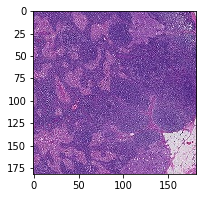

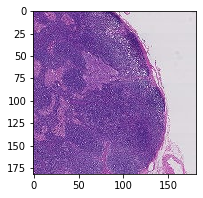

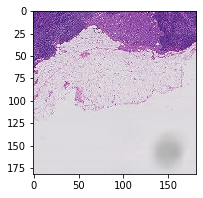

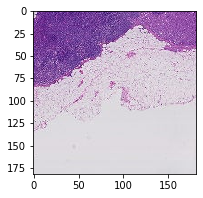

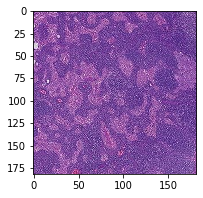

In [0]:
#positive patches
for p in patches_paths_pos_slide[:5]:
  img = np.load(p)
  plt.figure(figsize=(3,3))
  plt.imshow(img)


Shuffle each set of postive and negative paths, then get a sample of size n of each set and finally append them together to form a balanced dataset

In [0]:
patches_paths_pos_slide[:10]

['/content/patches/level6/positive/tumor_091_level6_x612_y306.npy',
 '/content/patches/level6/positive/tumor_091_level6_x663_y255.npy',
 '/content/patches/level6/positive/tumor_091_level6_x510_y561.npy',
 '/content/patches/level6/positive/tumor_091_level6_x459_y561.npy',
 '/content/patches/level6/positive/tumor_091_level6_x561_y255.npy',
 '/content/patches/level6/positive/tumor_091_level6_x357_y357.npy',
 '/content/patches/level6/positive/tumor_091_level6_x510_y306.npy',
 '/content/patches/level6/positive/tumor_091_level6_x612_y204.npy',
 '/content/patches/level6/positive/tumor_091_level6_x714_y408.npy',
 '/content/patches/level6/positive/tumor_091_level6_x663_y408.npy']

In [0]:
pos_labels = [[i,"tumor"] for i in patches_paths_pos_slide]
neg_labels = [[i,"no_tumor"] for i in patches_paths_neg_slide]
dataset = pd.DataFrame(data=pos_labels+neg_labels)
#dataset.append( [[i,"no_tumor"] for i in patches_paths_neg_slide])
dataset.columns=['path','label']


In [0]:
dataset

,path,label
0,/content/patches/level6/positive/tumor_091_lev...,tumor
1,/content/patches/level6/positive/tumor_091_lev...,tumor
2,/content/patches/level6/positive/tumor_091_lev...,tumor
3,/content/patches/level6/positive/tumor_091_lev...,tumor
4,/content/patches/level6/positive/tumor_091_lev...,tumor
...,...,...
151,/content/patches/level6/negative/tumor_091_lev...,no_tumor
152,/content/patches/level6/negative/tumor_091_lev...,no_tumor
153,/content/patches/level6/negative/tumor_091_lev...,no_tumor
154,/content/patches/level6/negative/tumor_091_lev...,no_tumor


In [0]:
dataset[dataset.label=='no_tumor']

,path,label
56,/content/patches/level6/negative/tumor_091_lev...,no_tumor
57,/content/patches/level6/negative/tumor_091_lev...,no_tumor
58,/content/patches/level6/negative/tumor_091_lev...,no_tumor
59,/content/patches/level6/negative/tumor_091_lev...,no_tumor
60,/content/patches/level6/negative/tumor_091_lev...,no_tumor
...,...,...
151,/content/patches/level6/negative/tumor_091_lev...,no_tumor
152,/content/patches/level6/negative/tumor_091_lev...,no_tumor
153,/content/patches/level6/negative/tumor_091_lev...,no_tumor
154,/content/patches/level6/negative/tumor_091_lev...,no_tumor


In [0]:
from sklearn.utils import shuffle
import random

N = 50 #sample size


#patches_paths_pos_slide_s = shuffle(patches_paths_pos_slide, random_state=42)
#patches_paths_neg_slide_s = shuffle(patches_paths_neg_slide, random_state=42)
dataset = dataset.sample(frac=1).reset_index(drop=True)

#pos_slides_sample = random.sample(patches_paths_pos_slide_s, N)
#neg_slides_sample = random.sample(patches_paths_neg_slide_s, N)
df_positive = dataset[dataset.label=='tumor'].sample(n=N, random_state=42)
df_negative = dataset[dataset.label=='no_tumor'].sample(n=N, random_state=42)

#append both samples together
df_balanced = pd.concat([df_positive, df_negative])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)


In [0]:
df_balanced

,path,label
0,/content/patches/level6/negative/tumor_091_lev...,no_tumor
1,/content/patches/level6/negative/tumor_091_lev...,no_tumor
2,/content/patches/level6/positive/tumor_091_lev...,tumor
3,/content/patches/level6/negative/tumor_091_lev...,no_tumor
4,/content/patches/level6/positive/tumor_091_lev...,tumor
...,...,...
95,/content/patches/level6/negative/tumor_091_lev...,no_tumor
96,/content/patches/level6/positive/tumor_091_lev...,tumor
97,/content/patches/level6/negative/tumor_091_lev...,no_tumor
98,/content/patches/level6/negative/tumor_091_lev...,no_tumor


In [0]:
print("len positive patches: {}, len negative patches: {}".format(len(patches_paths_pos_slide),len(patches_paths_neg_slide)))
print("dataset len: {}".format(len(dataset)))
print("balanced dataset len: {}".format(len(df_balanced)))
print("Tumor class len in balanced dataset: {}".format(len(df_balanced[df_balanced.label=="tumor"])))
print("No Tumor class len in balanced dataset: {}".format(len(df_balanced[df_balanced.label=="no_tumor"])))

len positive patches: 56, len negative patches: 100
dataset len: 156
balanced dataset len: 100
Tumor class len in balanced dataset: 50
No Tumor class len in balanced dataset: 50


From the balanced dataset create a split of Train/Test/Validation sets in a ratio of 80:15:5

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
#sss.get_n_splits(df_balanced, df_balanced.label)

#split first in train/temp sets of 0.7 and 0.3
for train_index, test_index in sss1.split(df_balanced, df_balanced.label):
  train_idxs = train_index
  tmp_idxs = test_index

#get train dataset
train_set = df_balanced.iloc[train_idxs]  
temp = df_balanced.iloc[tmp_idxs]

#split the 0.3 set from before in 0.25 test set and 0.05 validation test
for test_index, val_index in sss2.split(temp, temp.label):
  test_idxs = test_index
  val_idxs = val_index

#get test and validation sets
test_set = df_balanced.iloc[test_idxs]
val_set = df_balanced.iloc[val_idxs]

In [0]:
train_set

,path,label
74,/content/patches/level6/positive/tumor_091_lev...,tumor
8,/content/patches/level6/positive/tumor_091_lev...,tumor
6,/content/patches/level6/positive/tumor_091_lev...,tumor
26,/content/patches/level6/positive/tumor_091_lev...,tumor
49,/content/patches/level6/positive/tumor_091_lev...,tumor
...,...,...
38,/content/patches/level6/negative/tumor_091_lev...,no_tumor
70,/content/patches/level6/negative/tumor_091_lev...,no_tumor
53,/content/patches/level6/positive/tumor_091_lev...,tumor
46,/content/patches/level6/negative/tumor_091_lev...,no_tumor


In [0]:
print("Train set len: {}".format(train_set.index.size))
print("Tumor class len in train set: {}".format(len(train_set[train_set.label=="tumor"])))
print("Test set len: {}".format(test_set.index.size))
print("Tumor class len in test set: {}".format(len(test_set[test_set.label=="tumor"])))
print("Validation set len: {}".format(val_set.index.size))
print("Tumor class len in val set: {}".format(len(val_set[val_set.label=="tumor"])))


Train set len: 80
Tumor class len in train set: 40
Test set len: 15
Tumor class len in test set: 8
Validation set len: 5
Tumor class len in val set: 4
